# Описание проекта

Интернет-магазин продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные до 2016 года о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нужно выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  

## Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/datasets/games.csv')
data.info()
display(data.head())
display(data.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN


Проверим на дубликаты

In [2]:
print('Количество дубликатов: ', data.duplicated().sum())

Количество дубликатов:  0


В таблице много пропусков, посчитаем их количество

In [3]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

В таблице 16715 записей. Названия столбцов имеют символы в верхнем и нижнем регистре. Тип данных столбца Year_of_Release не соответствует хранимым данным, также вероятно это относится к столбцам Critic_Score и User_Score. Имеются пропуски в столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score и Rating. Возможно что-то можно восстановить.

## Подготовка данных

Заменим названия столбцов (приведем их к нижнему регистру)

In [4]:
data.columns = data.columns.str.lower()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Посмотрим наличие скрытых дубликатов в столбцах с категориальными данными platform, genre и rating.

In [5]:
for column in ['platform', 'genre', 'rating']:
    print(column + ':')
    display(data[column].value_counts())
    print('********************')

platform:


PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       29
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

********************
genre:


Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

********************
rating:


E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

********************


Дубликатов не обнаружено. Посмотрим на данные в столбце critic_score

In [6]:
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

Пррпуски вероятно связаны с тем, что не все игры и не для всех платформ удостаиваютя оценок критиков. Оставим пропуски как есть. Оценки критиков имеют целое значение. Приведем тип данных столбца к int

In [7]:
data['critic_score'] = data['critic_score'].astype('Int64')
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Посмотрим на данные в столбце user_score

In [8]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце значения подразумевают вещественный тип, но хранятся в формате строк и помимо пропусков (nan) содержат еще и записи 'tbd'. tbd - вероятно аббревиатура от английского To Be Determined (будет определено). И видимо подразумевает не определенные или отсутствующие данные оценки пользователей. Для упрощения последующей обработки заменим значение 'tbd' на NaN и приведем тип к float.

In [9]:
data.loc[(data['user_score'] == 'tbd'), 'user_score'] = np.nan
data['user_score'] = data['user_score'].astype('float')

In [10]:
data['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

Посмотрим на пропуски в столбце name

In [11]:
data[data['name'].isna() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Восстановить пропуски в этих строках вряд ли возможно, кроме названий еще отсутствуют жанры и нет оценок и рейтинга нужных в наших дальнейших исследованиях. Удалим эти строки.

In [12]:
data.dropna(subset=['name'], inplace=True)
data['name'].isna().sum()

0

Посмотрим на данные в столбце rating

In [13]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Вероятно пропуски в столбце обусловлены не полученем игрой соответствующего рейтинга от ESRB по различным причинам (игры вышли до 90-х годов, распространялись в странах вне зоны действия стандартов ESRB и др.), либо отсутствием информации в источниках получения данных. Узнаем количество пропусков.

In [14]:
data['rating'].isna().sum()

6764

Проверим совпадают ли рейтинги одних и тех же игр на разных патформах

In [15]:
data.groupby('name').rating.nunique().sort_values(ascending=False).head(10)

name
The Sims 2: Castaway                                              3
Dawn of Discovery                                                 3
WRC: FIA World Rally Championship                                 3
Ghostbusters: The Video Game                                      3
DiRT 2                                                            3
The Chronicles of Narnia: The Lion, The Witch and The Wardrobe    3
Shaun White Snowboarding                                          3
Disney's Chicken Little: Ace In Action                            2
Oddworld: Munch's Oddysee                                         2
DanceDanceRevolution                                              2
Name: rating, dtype: int64

In [16]:
display(data.query('name == "Dawn of Discovery"'))
display(data.query('name == "DanceDanceRevolution"'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5026,Dawn of Discovery,PC,2009.0,Simulation,0.00,0.32,0.0,0.06,82,8.8,T
7809,Dawn of Discovery,Wii,2009.0,Simulation,0.12,0.06,0.0,0.02,81,8.5,E10+
10342,Dawn of Discovery,DS,2009.0,Simulation,0.07,0.03,0.0,0.01,82,7.3,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5381,DanceDanceRevolution,Wii,2010.0,Simulation,0.28,0.04,0.0,0.02,NaN,NaN,E
7914,DanceDanceRevolution,PS3,2010.0,Simulation,0.12,0.05,0.0,0.02,60,NaN,E10+
11444,DanceDanceRevolution,X360,2011.0,Simulation,0.08,0.00,0.0,0.01,NaN,NaN,E10+


Рейтинги игр для разных платформ могут быть разными, поэтому определить значения для пропусков затруднительно. Так как данные в столбце относятся к категориальным, заполним пропуски значениями новой категории, указав что рейтинг не определен - "undefined".

In [17]:
data['rating'] = data['rating'].fillna('undefined')
data['rating'].isna().sum()

0

Рассмотрим данные в столбце year_of_release:

In [18]:
data['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

Данные в столбце нужно привести к типу int. Посмотрим на количество пропусков

In [19]:
data['year_of_release'].isna().sum()

269

Посмотрим есть ли игры для разных платформ, выпущенные в разные годы

In [20]:
data.groupby('name').year_of_release.nunique().sort_values(ascending=False)

name
SimCity 2000                                  5
Monopoly                                      5
Terraria                                      4
Bomberman                                     4
Mortal Kombat                                 4
                                             ..
Demon Chaos                                   0
Shorts                                        0
Test Drive Unlimited 2                        0
Our House Party!                              0
Writing and Speaking Beautiful Japanese DS    0
Name: year_of_release, Length: 11559, dtype: int64

In [21]:
display(data.query('name == "SimCity 2000"'))
display(data.query('name == "Mortal Kombat"'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
769,SimCity 2000,PC,1992.0,Simulation,1.20,0.84,0.00,0.10,NaN,NaN,undefined
1646,SimCity 2000,PS,1996.0,Simulation,0.68,0.46,0.00,0.08,NaN,NaN,undefined
4066,SimCity 2000,SNES,1995.0,Simulation,0.00,0.00,0.49,0.00,NaN,NaN,undefined
6219,SimCity 2000,SAT,1994.0,Simulation,0.00,0.00,0.28,0.00,NaN,NaN,undefined
10408,SimCity 2000,GBA,2003.0,Simulation,0.08,0.03,0.00,0.00,62,7.8,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
513,Mortal Kombat,PS3,2011.0,Fighting,1.98,0.53,0.0,0.34,84,8.4,M
564,Mortal Kombat,GEN,1992.0,Fighting,1.95,0.63,0.0,0.09,NaN,NaN,undefined
791,Mortal Kombat,X360,2011.0,Fighting,1.63,0.31,0.0,0.16,86,8.3,M
3102,Mortal Kombat,PSV,2012.0,Fighting,0.42,0.13,0.0,0.10,85,7.8,M
15551,Mortal Kombat,PC,1994.0,Fighting,0.02,0.00,0.0,0.00,NaN,NaN,undefined


Разница в датах релиза иногда в десятки лет, выходит заполнять по другим платформам не вариант. Доля пропусков в столбце year_of_release незначительная, удалим эти значения.

In [22]:
data.dropna(subset=['year_of_release'], inplace=True)
data['year_of_release'].isna().sum()

0

Пропуски удалены. Теперь приведем тип столбца year_of_release к int

In [23]:
data['year_of_release'] = data['year_of_release'].astype('Int64')

In [24]:
display(data.head(10))
data.info()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,undefined
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,undefined
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,undefined
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,undefined


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null Int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null Int64
user_score         7463 non-null float64
rating             16444 non-null object
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.5+ MB


Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец total_sales

In [25]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,undefined,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,undefined,31.38


## Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы 

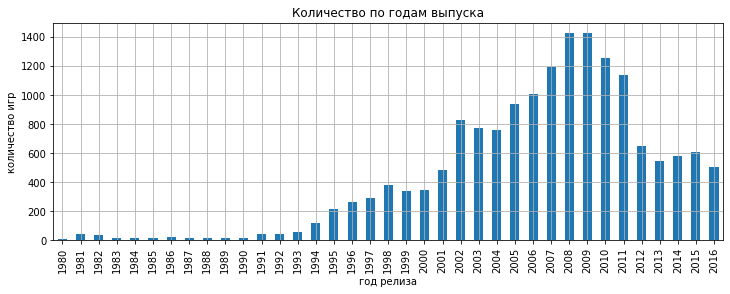

In [26]:
ax = (
        data.pivot_table(index='year_of_release', values='name', aggfunc='count')
        .plot(
            kind='bar',
            grid=True,
            figsize=(12, 4))
)
ax.set_title('Количество по годам выпуска')
ax.set_xlabel('год релиза')
ax.set_ylabel('количество игр')
ax.legend().remove()
plt.show()

Выпуск игр стал расти с начала 90-х годов с развитием и ростом доступности персональных компьютеров и игровых приставок. Рост достиг своего пика в 2008-2009 году, после чего наблюдается снижение до 2013 года. Скорее всего снижение произошло с развитием смартфонов, экраны телефонов подросли, появились планшеты. С 2013 года выпускается по 500-600 игр в год, что примерно соответствует уровню 2001 года.

Посмотрим, как менялись продажи по платформам

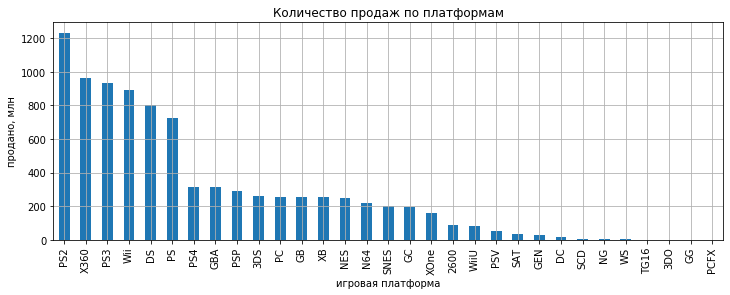

In [27]:
ax = (
        data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
        .sort_values(by='total_sales', ascending=False)
        .plot(
            kind='bar',
            grid=True,
            figsize=(12, 4))
)
ax.set_title('Количество продаж по платформам')
ax.set_xlabel('игровая платформа')
ax.set_ylabel('продано, млн')
ax.legend().remove()
plt.show()

Платформы с наибольшими суммарными продажами за все время это PS2, X360, PS3, Wii, DS и PS. Посмотрим для них распределение продаж по годам.

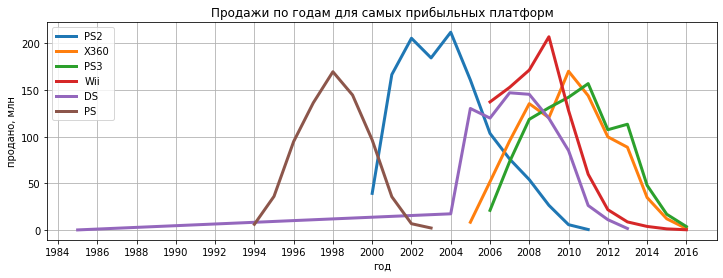

In [28]:
top_platforms = data.groupby(by='platform').agg(
    total_sales=('total_sales', 'sum')).reset_index().sort_values(
    by='total_sales', ascending=False)['platform'].head(6).to_list()
fig, ax = plt.subplots()

for platform in top_platforms:
    subset = data[data['platform'] == platform].pivot_table(
                index='year_of_release', values='total_sales',
                    aggfunc='sum')
    ax.plot(subset, label = platform, linewidth = 3)

ax.legend(loc='upper left')
ax.set_title('Продажи по годам для самых прибыльных платформ')
ax.set_xlabel('год')
ax.set_ylabel('продано, млн')
ax.set_xticks(np.arange(1984, 2018, 2.0))
ax.grid()

fig.set_figheight(4)
fig.set_figwidth(12)
plt.show()  

По графику видно, что самые доходные платформы уже исчерпали свои возможности  и половина из них уже исчезли совсем. Характерный срок от появления до заката новых платформ около 10 лет. С момента появления до пика и начала падения продаж проходит в среднем 4 года. Обращает на себя провал на кривой продаж в 2009 году для платформы X360, судя по графику он может быть связан с выросшей популярностью в этот период консолей Nintendo - последней консолью продемонстрировавшей рекордные продажи.

Рассмотрим глобальные продажи в разрезе платформ за последние 10 лет

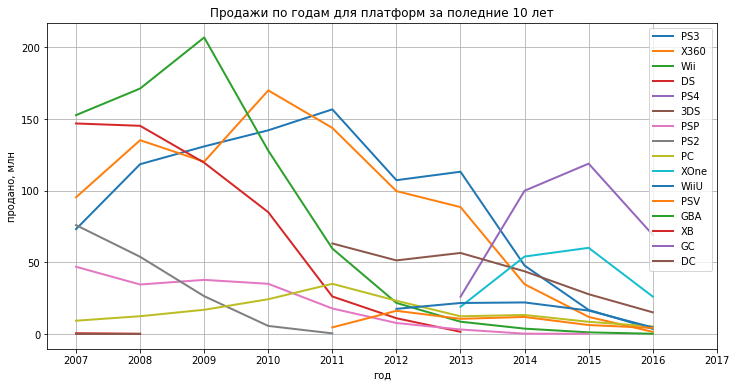

In [29]:
dt_last_10_years = data.query('year_of_release > 2006')

fig, ax = plt.subplots()
names_platforms_last_10_years = dt_last_10_years.groupby(by='platform').agg(
    total_sales=('total_sales', 'sum')).reset_index().sort_values(
    by='total_sales', ascending=False)['platform'].to_list()

for platform in names_platforms_last_10_years:
    subset = dt_last_10_years[dt_last_10_years['platform'] == platform].pivot_table(
                index='year_of_release', values='total_sales',
                    aggfunc='sum')
    ax.plot(subset, label = platform, linewidth = 2)

ax.legend(loc='upper right')
ax.set_title('Продажи по годам для платформ за поледние 10 лет')
ax.set_xlabel('год')
ax.set_ylabel('продано, млн')
ax.set_xticks(np.arange(2007, 2018, 1.0))
ax.grid()

fig.set_figheight(6)
fig.set_figwidth(12)
plt.show()  

За последние 10 лет прослеживается общая тенденция к снижению продаж. В последние 3 года отмечался рост только для 2-х платформ: PlayStation 4 (PS4) и Xbox One (XOne), но и они в последний год демонстрировали снижение. Снижение последнего года может быть связано с тем, что данные за 2016 год у нас неполные, как и указано в задании. Также можно отметить снижающиеся но все еще относительно высокие продажи для консоли Nintendo 3DS (3DS). Продажи для этой платформы стртовали в 2010 году и еще не прошел 10-ти летний цикл. Таким образом можно выделить 3 потенциально прибыльные платформы: PlayStation 4 (PS4), Xbox One (XOne), Nintendo 3DS (3DS).

Исходя из предыдущего анализа можно определить актуальный период как последние 4 года (с 2013 по 2016 г.)  
2013г - год релиза последнего поколения платформ от Microsoft и Sony, cамых актуальных на конец анализируемого периода. И 4 года это средний период с момента появления до пика развития игровой платформы. Возьмем данные за соответствующий актуальный период.

In [30]:
dt_last_4_years = data.query('year_of_release > 2012')
dt_last_4_years.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,undefined,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,undefined,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62


Для выбранных платформ построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Вначале сделаем срез данных по интересующим платформам.

In [31]:
data_promising_platforms = dt_last_4_years.query(
    'platform == "PS4" or platform == "XOne" or platform == "3DS"')
data_promising_platforms.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,undefined,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,undefined,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,undefined,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58


Посмотрим на числовое описание данных total_sales в выборке

In [32]:
data_promising_platforms['total_sales'].describe()

count    942.000000
mean       0.654682
std        1.410325
min        0.010000
25%        0.050000
50%        0.155000
75%        0.577500
max       14.630000
Name: total_sales, dtype: float64

Максимальное значение 14.63 при среднем 0.65 и стандартном отклонении 1.41. В столбце есть выбросы, при построении графика ограничим значения по оси 'y' в 2 млн.

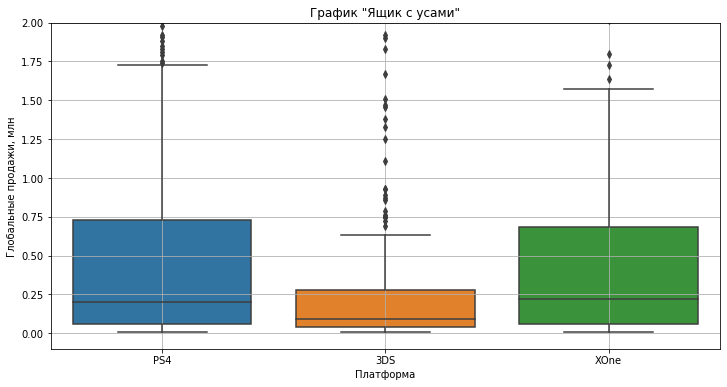

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_promising_platforms, x='platform', y='total_sales')
plt.ylim(-0.1, 2)
plt.grid()
plt.title('График "Ящик с усами"')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи, млн')
plt.show()

Медианные продажи для 2-х самых перспективных платформ (PlayStation 4 и Xbox One) близки, чуть выше медиана у XOne. Межквартильный размах у них также схож, но у PS4 размах чуть шире и при этом длиннее верхний ус, что указывает на большее количество популярных игр на этой платформе.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Возьмем данные для платформы PS4.

In [34]:
data_ps4 = data_promising_platforms.query('platform == "PS4"')
data_ps4.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,undefined,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,undefined,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83,5.7,M,7.66


In [35]:
print('Матрица корреляции между оценками пользователей, критиков и продажами')
corr_score_to_sales_ps4 = data_ps4[['critic_score', 'user_score', 'total_sales']].corr()
display(corr_score_to_sales_ps4)

Матрица корреляции между оценками пользователей, критиков и продажами


,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
total_sales,0.406568,-0.031957,1.000000


Для автоматиазации рисования диаграмм рассеяния создадим функцию

In [36]:
def plot_scatter(data):
    fig, ax = plt.subplots()
    ax.scatter(data['critic_score'],
            data['total_sales'],
            color='blue',
            label = 'Оценка критиков'
            )
    ax.scatter(data['user_score'] * 10, #умножаем на 10 для масштабирования на графике с оценками критиков
            data['total_sales'],
            color='red',
            label = 'Оценка пользователей',
            alpha=0.5
            )
    ax.legend(loc='upper left')
    ax.set_title('Диаграмма рассеяния зависимости продаж от отзывов')
    ax.set_xlabel('Отзывы')
    ax.set_ylabel('Глобальные продажи, млн')
    ax.grid()
    fig.set_figheight(4)
    fig.set_figwidth(12)
    plt.show()

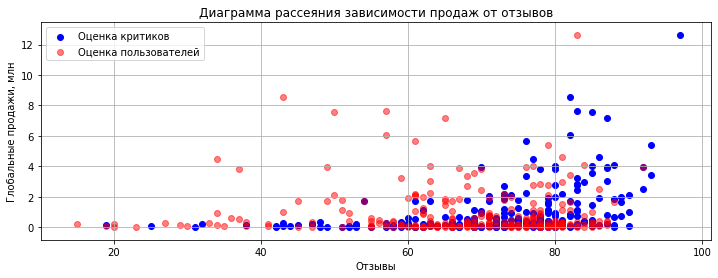

In [37]:
plot_scatter(data_ps4)

Рассчитанная корреляция между оценками пользователей и продажами оценивается как "очень слабая", между оценками критиков и продажами корреляция выше, но оценивается все еще как "слабая". Примечательно, что коэффициент корреляции между оценками критиков и пользователей 0.56 ("средняя корреляция") - мнение критиков и пользователей не всегда совпадает.  
Диаграмма рассеяния демонстрирует умеренную зависимость между оценками и продажами, при этом отзывы критиков заметно чаще влияют на покупки - высоких продаж становится больше после оценки критиков в 60 и более баллов, видимо к мнению критиков пользователи прислушиваются. Об оценках пользователей такого нельзя сказать.


Проверим эти выводы применительно к другим платформам. Возьмем для проверки топ 3 платформ с наибольшими продажами.

Матрица корреляции и диаграмма рассеяния для платформы: PS3


,critic_score,user_score,total_sales
critic_score,1.00000,0.630960,0.433460
user_score,0.63096,1.000000,0.126033
total_sales,0.43346,0.126033,1.000000


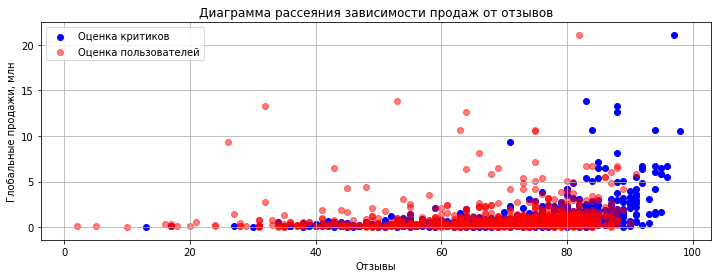

***************************************************************************************
Матрица корреляции и диаграмма рассеяния для платформы: X360


,critic_score,user_score,total_sales
critic_score,1.000000,0.621495,0.396910
user_score,0.621495,1.000000,0.114627
total_sales,0.396910,0.114627,1.000000


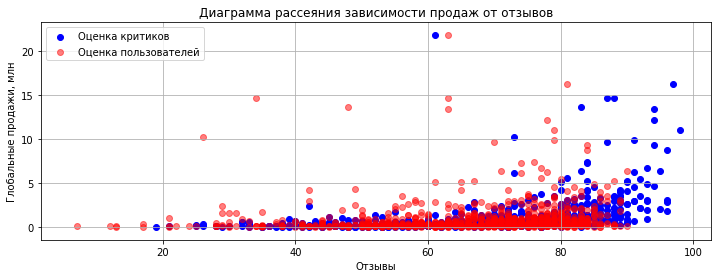

***************************************************************************************
Матрица корреляции и диаграмма рассеяния для платформы: Wii


,critic_score,user_score,total_sales
critic_score,1.000000,0.685395,0.237735
user_score,0.685395,1.000000,0.141303
total_sales,0.237735,0.141303,1.000000


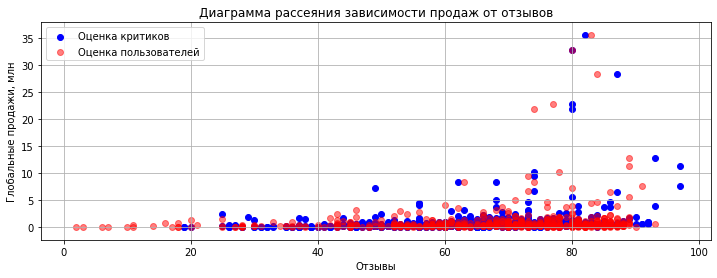

***************************************************************************************


In [38]:
names_platforms_top3 = names_platforms_last_10_years[0:3]

for name_platform in names_platforms_top3:
    print('Матрица корреляции и диаграмма рассеяния для платформы:', name_platform)
    data_for_platform = dt_last_10_years.query('platform == @name_platform')
    display(data_for_platform[['critic_score', 'user_score', 'total_sales']].corr())
    
    plot_scatter(data_for_platform)
    
    print('***************************************************************************************')    

Немного выделяется платформа Nintendo Wii, оценки пользователей и критиков здесь чаще совпадают.
Рассчитанные коэффициенты корреляции и построенные диаграммы рассеяния для всех платформ очень схожи и демонстрируют некоторую зависимость продаж с ростом оценок (в большей степени критиков),  а следовательно ранее сделанные выводы о зависимостях между оценками критиков, пользователей и объемами продаж можно считать верными.

Рассмотрим общее распределение игр по жанрам. 

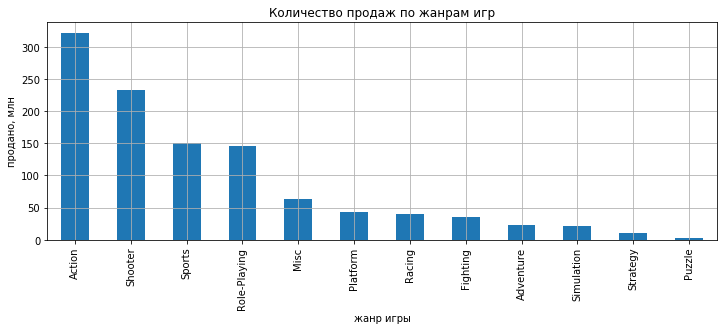

In [39]:
ax = (
        dt_last_4_years.pivot_table(index='genre', values='total_sales', aggfunc='sum')
        .sort_values(by='total_sales', ascending=False)
        .plot(
            kind='bar',
            grid=True,
            figsize=(12, 4))
)
ax.set_title('Количество продаж по жанрам игр')
ax.set_xlabel('жанр игры')
ax.set_ylabel('продано, млн')
ax.legend().remove()
plt.show()

Самый прибыльный жанр с большим отрывом - "Action". Также в тройку лидеров входят шутеры и спортивные симуляторы, имеющие прмерно одинаковый уровень продаж. Наибольшие продажи приносят игры с активным гейм-плеем, где современные консоли позволяют наслаждаться качественной графикой и динамичными сюжетами. А вот когда-то популярные размеренные игры-стратегии и пазлы-головоломки находятся в конце списка и не могут похвастаться высокими продажами.

 Посмотрим на количество игр представленных в каждом жанре

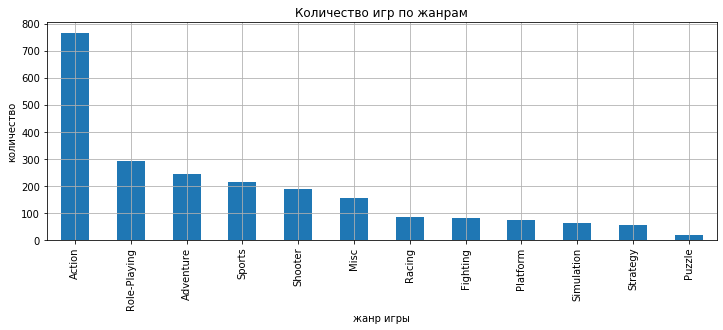

In [40]:
ax = (
        dt_last_4_years['genre'].value_counts()
        .plot(
            kind='bar',
            grid=True,
            figsize=(12, 4))
)
ax.set_title('Количество игр по жанрам')
ax.set_xlabel('жанр игры')
ax.set_ylabel('количество')
ax.legend().remove()
plt.show()

Игры в жанре Action превышают по количеству ближайшего конкурента больше чем в 2.5 раза. Для определения продаваемых жанров воспользуемся подсчетом медианных продаж. Посмотрим на результаты

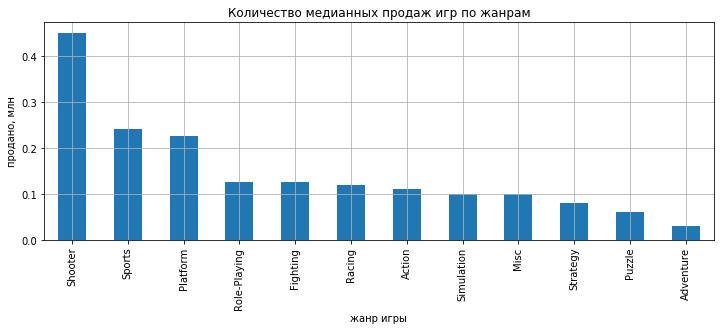

In [41]:
ax = (
        dt_last_4_years.pivot_table(index='genre', values='total_sales', aggfunc='median')
        .sort_values(by='total_sales', ascending=False)
        .plot(
            kind='bar',
            grid=True,
            figsize=(12, 4))
)
ax.set_title('Количество медианных продаж игр по жанрам')
ax.set_xlabel('жанр игры')
ax.set_ylabel('продано, млн')
ax.legend().remove()
plt.show()

Картина несколько поменялась. В тройке лидеров по-прежнему Shooter и Sports, при этом шутеры продаются почти в 2 раза лучше. Заметно ближе к топу переместился жанр Platform. Игры жанра Action переместились в середину, видимо рекордные общие продажи обеспечивали несколько популярных игр этого жанра. В конце списка все те же Strategy, Puzzle, Adventure.

## Составление портрета пользователя региона

Определим для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5). 

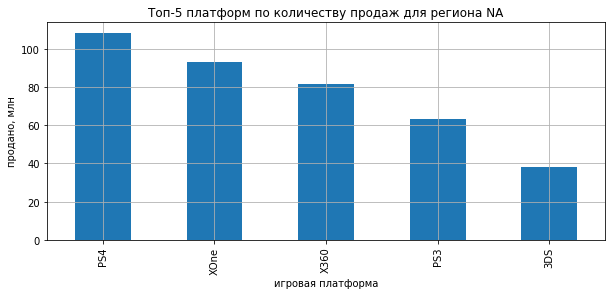

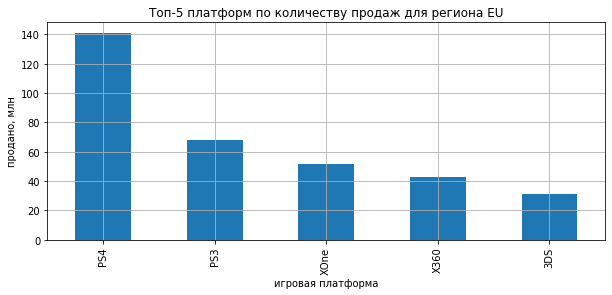

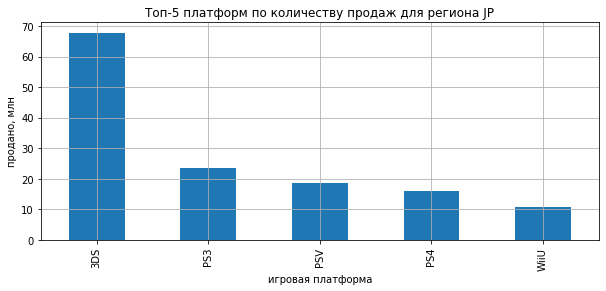

In [42]:
dict_region = {'NA':'na_sales', 'EU':'eu_sales', 'JP':'jp_sales'}

for region in dict_region.keys():    
    ax = (
        dt_last_4_years.pivot_table(index='platform', values=dict_region[region], aggfunc='sum')
        .sort_values(by=dict_region[region], ascending=False).head(5)
        .plot(
            kind='bar',
            grid=True,
            figsize=(10, 4))
    )
    ax.set_title('Топ-5 платформ по количеству продаж для региона ' + region)
    ax.set_xlabel('игровая платформа')
    ax.set_ylabel('продано, млн')
    ax.legend().remove()
    plt.show()

Лидеры среди успешных платформ для разных регионов несколько отличаются. Для северной америки тройка лидеров это платформа Sony PS4 и  2 платформы от Microsoft: Xbox One и Xbox 360, для Европы - Sony PS4 и PS3 и далее Xbox, а для Японии - лидер портативная консоль Nintendo 3DS. Заметно, что на популярность платформ влияет национальная принадлежность компаний-разработчиков. Особенно выделяется Япония - весь топ-5 японские консоли. Европе ближе также японские платформы, но и продукция Microsoft не сильно уступает лидеру - Sony. Японские компании - несомненный лидер в этой отрасли.    

Определим для этих же регионов самые популярные жанры (топ-5).

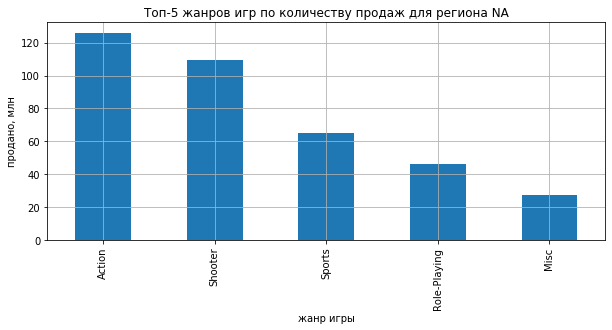

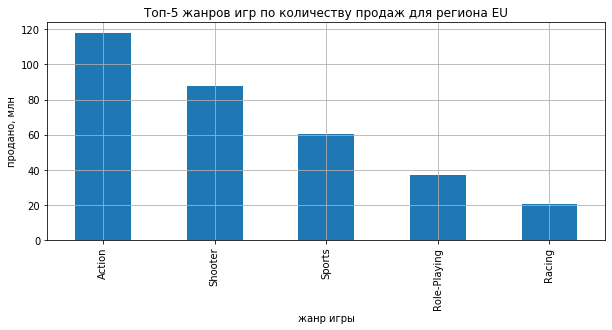

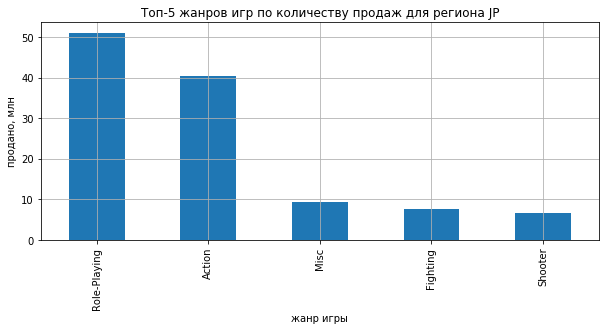

In [43]:
for region in dict_region.keys():    
    ax = (
        dt_last_4_years.pivot_table(index='genre', values=dict_region[region], aggfunc='sum')
        .sort_values(by=dict_region[region], ascending=False).head(5)
        .plot(
            kind='bar',
            grid=True,
            figsize=(10, 4))
    )
    ax.set_title('Топ-5 жанров игр по количеству продаж для региона ' + region)
    ax.set_xlabel('жанр игры')
    ax.set_ylabel('продано, млн')
    ax.legend().remove()
    plt.show()

Для регионов NA и EU предпочтения по жанрам почти одинаковы. Лидирует жанр Action, также популярны жанры Shooter и Sports. В конце списка небольшие отличия, Европа любит гонки. Япония снова демонстрирует свои особенности: в лидерах здесь Role-Playing Game, также популярен жанр Action, кроме того в пятерке популярных жанров появляется Fighting, что не удивительно для родины многих боевых исскуств. Эти все отличия вероятно связаны как с национальными особенностями и предпочтениями пользователей, так и с особенностями популярных в этих регионах игровых платформ.

Посмотрим, как влияет рейтинг ESRB на продажи в отдельном регионе.

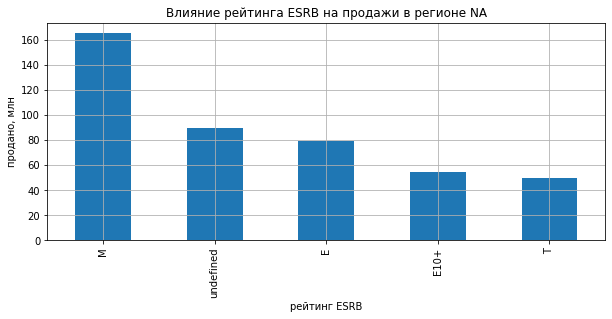

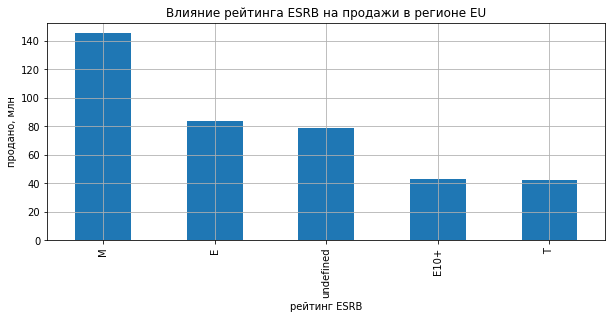

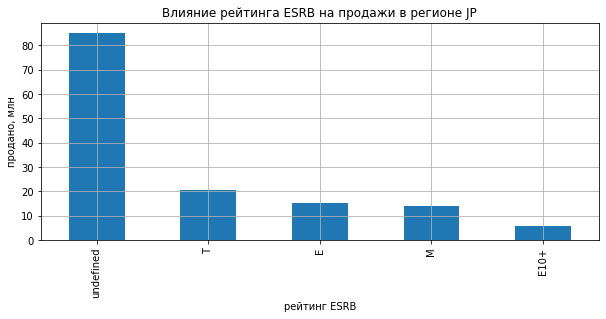

In [44]:
for region in dict_region.keys():    
    ax = (
        dt_last_4_years.pivot_table(index='rating', values=dict_region[region], aggfunc='sum')
        .sort_values(by=dict_region[region], ascending=False)
        .plot(
            kind='bar',
            grid=True,
            figsize=(10, 4))
    )
    ax.set_title('Влияние рейтинга ESRB на продажи в регионе ' + region)
    ax.set_xlabel('рейтинг ESRB')
    ax.set_ylabel('продано, млн')
    ax.legend().remove()
    plt.show()

Опять картина для Европы и Америки очень схожа, больше всех продаж приносят игры с рейтингом М (для взрослых) и Е (для всех возрастных групп), большая доля игр не получила рейтинга (по крайней мере в нашем исследовании этих данных нет). Примечательно много игр с отсутсвующим ретингом  ESRB для Японии, вероятно там используется своя система установления рейтингов игр.

 ## Проверка гипотез

Проверим некоторые гипотезы. 
1. "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые."

Сформулируем нулевую гипотезу для этого утверждения:  
"Средние пользовательские рейтинги платформ Xbox One и PC равны".  
Тогда альтернативная гипотеза:  
"Средние пользовательские рейтинги платформ Xbox One и PC не равны".

Сделаем выбоки данных для двух платформ

In [45]:
user_scores_XOne = data[(data['platform'] == 'XOne') & (
                        data['user_score'].notnull())].user_score
user_scores_PC = data[(data['platform'] == 'PC') & (
                        data['user_score'].notnull())].user_score

Воспользуемся методом проверки гипотезы о равенстве средних двух генеральных совокупностей. Для этого создадим функцию выполняющую такую проверку. 

In [46]:
# Функция для проверки гипотезы о равенстве средних двух генеральных совокупностей
# Входные данные: выборки данных и заданный уровень значимости
# В функции определеятся значения параметра equal_var на основании сравнения дисперсии двух выборок,
# дисперсии считаются разными, если отличаются больше чем на 5%

def null_hypothesis_check(data1, data2, alpha_for_check):
    var_data1 = data1.var()
    var_data2 = data2.var()
    equal_var_for_check = True
    if (max(var_data1, var_data2) / min(var_data1, var_data2)) > 1.05:
        equal_var_for_check = False
    alpha = alpha_for_check
    results = st.ttest_ind(data1.to_list(), data2.to_list(), equal_var=equal_var_for_check)
    print('p-значение:', results.pvalue)
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу') 
    
    

Для снижения вероятности ошибочного отклонения нулевой гипотезы в результате случайной ошибки, критерий (уровень) значимости предлагается установить на уровне 0.01. Проверим нулевую гипотезу.

In [47]:
null_hypothesis_check(user_scores_XOne, user_scores_PC, 0.01)

p-значение: 4.5385802963771776e-06
Отвергаем нулевую гипотезу


Вероятность того, что "Средние пользовательские рейтинги платформ Xbox One и PC равны" - низка, делаем вывод, что, скорее всего, наше предположение неверно и принимаем альтернативную гипотезу, что "Средние пользовательские рейтинги платформ Xbox One и PC не равны"

2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.  

Сформулируем нулевую гипотезу для этого утверждения:  
"Средние пользовательские рейтинги жанров Action и Sports равны".  
Альтернативная гипотеза:  
"Средние пользовательские рейтинги жанров Action и Sports не равны".

Сделаем выбоки данных для двух жанров

In [48]:
user_scores_genre_Action = data[(data['genre'] == 'Action') & (
                        data['user_score'].notnull())].user_score
user_scores_genre_Sports = data[(data['genre'] == 'Sports') & (
                        data['user_score'].notnull())].user_score

Критерий значимости установим на том же уровне 0.01. Проверим нулевую гипотезу

In [49]:
null_hypothesis_check(user_scores_genre_Action, user_scores_genre_Sports, 0.01)

p-значение: 0.07370217419278534
Не получилось отвергнуть нулевую гипотезу


Вероятность того, что "Средние пользовательские рейтинги жанров Action и Sports равны" относительно высока, данные не дают основания отвергнуть это предположение. Принимаем нулевую гипотезу.

## Общий вывод

Проведен анализ исторических данных до 2016 года о продажах игр, оценках пользователей и экспертов, жанров и платформ.

Выпуск компьютерных игр бурно начал расти с начала 90-х годов с развитием и ростом доступности персональных компьютеров и игровых приставок и достиг своего пика в 2008-2009 году, после чего наблюдается постепенное снижение, вероятно связанное развитием смартфонов и планшетов.

Платформы с наибольшими суммарными продажами за все время это PS2, X360, PS3, Wii, DS и PS
Характерный срок от появления до заката новых платформ около 10 лет. С момента появления до пика и начала падения продаж проходит в среднем 4 года. 

За последние 10 лет прослеживается общая тенденция к снижению продаж. В последние 3 года отмечался рост только для 2-х платформ: PlayStation 4 (PS4) и Xbox One (XOne), но и они в последний год демонстрировали снижение, что может быть связано с тем, что данные за 2016 год неполные. На конец 2016 года можно выделить 3 все еще потенциально прибыльные платформы: PlayStation 4 (PS4), Xbox One (XOne), Nintendo 3DS (3DS). Медианные продажи для 2-х самых перспективных платформ PlayStation 4 и Xbox One близки, но у PS4 больше игр пользующихся спросом.

Анализ влияния озывов пользователей и критиков на продажи показал, что отзывы критиков заметно чаще влияют на покупки - высоких продаж становится больше после оценки критиков в 60 и более баллов. Об оценках пользователей такого нельзя сказать. 

По жанрам игр в тройке лидеров Shooter, Sports и Platform, при этом шутеры продаются почти в 2 раза лучше. Высокие общие продажи в жанре Action видимо обеспечивают несколько популярных игр этого жанра. А вот игры Strategy, Puzzle, Adventure не так популярны.

Проведен анализ предпочтений пользователей в разрезе географических регионов. В Европе и Америке уверенно лидирует Sony PS4. Замечено, что в некоторых регионах на популярность платформ влияет национальная принадлежность компаний-разработчиков. Для северной америки в топ-3 2 из 3 платформы Microsoft, для Европы - Sony, а для Японии - все платформы национальные. Для регионов NA и EU предпочтения по жанрам практически одинаковы (лидирует Action), также популярны жанры Shooter и Sports. Япония демонстрирует свои особенности: в лидерах здесь Role-Playing Game, кроме того в пятерке популярных жанров появляется Fighting. 

Для Европы и Америки больше всех продаж приносят игры с рейтингом М (для взрослых) и Е (для всех возрастных групп). Примечательно много игр с отсутсвующим ретингом ESRB для Японии, вероятно там используется своя система установления рейтингов игр.

На основании проведенных рассчетов получены результаты, что вероятность того, что средние пользовательские рейтинги платформ Xbox One и PC равны - крайне низкая, и скорее всего средние пользовательские рейтинги платформ Xbox One и PC не равны. А также вероятность того, что средние пользовательские рейтинги жанров Action и Sports равны относительно высока, и не дает основания отвергнуть это предположение.